# scikit-learn and fairness, tools and challenges

### Adrin Jalali
### Berlin, scikit-learn, fairlearn
### Zalando's Center of Excellence for Algorithmic Privacy and Fairness
#### @adrinjalali, https://adrin.info
#### https://github.com/adrinjalali/talks

In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml
from bokeh.plotting import figure, show, output_notebook
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import SGDClassifier
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from sklearn import set_config
set_config(display='diagram')
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

output_notebook()

Loading BokehJS ...

## Challenges
- Socioeconomical challenges
  - We're biased, our data is biased
  - Structural challenges in the society
    - Systematic and institutional racism, sexism, etc
- What does it mean to be fair?
  - Many different metrics
    - Their consequences
    - How legislation and certain ethical concerns translate into them
    - Impossibility theorem
  - Individual vs Group fairness
- Fairness vs. Model Performance
  - Convincing stakeholders to accept the loss

## Challenges (cntd.)
- Tensions with policies and legislation
  - GDPR protects the following attributes:
    - racial or ethnic origin;
    - political opinions;
    - religious or philosophical beliefs;
    - trade union membership;
    - processing of genetic data;
    - biometric data for the purpose of uniquely identifying a natural person;
    - health;
    - sex life or sexual orientation.
  - Excluding these attributes doesn't make models _fair_.
- Skills and tools gap among practitioners
  - Include these issues in curiculums
  - Tools which can be used with ease and work with the existing workflows and pipelines -> this talk

## Overview
- Example classification
- Fairness related metrics
- Try to "repair" the issue
- Some existing tools 
- scikit-learn API requirements and limitations

## UCI Adult Dataset
For this example we use the UCI adult dataset where the objective is to predict whether a person makes more or less than $50,000 a year.

Note: This data includes a _sex_ attribute and not _gender_, and sees the attribute as binary, all of which are problematic!

In [2]:
data = fetch_openml(data_id=1590, as_frame=True)
X, y = data.data, data.target
X

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States
48838,40.0,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States
48839,58.0,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States
48840,22.0,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States


One-hot-encoding of the categorical variables using [`pandas.get_dummies`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html), and we go from 14 columns to 105

(later we'll talk about why we shouldn't be doing this!)

In [3]:
# one-hot-encoding of the categorical variables
X = pd.get_dummies(X)
y = (y == ">50K").astype(int)
X

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Private,workclass_Self-emp-not-inc,workclass_Self-emp-inc,workclass_Federal-gov,...,native-country_Guatemala,native-country_Nicaragua,native-country_Scotland,native-country_Thailand,native-country_Yugoslavia,native-country_El-Salvador,native-country_Trinadad&Tobago,native-country_Peru,native-country_Hong,native-country_Holand-Netherlands
0,25.0,226802.0,7.0,0.0,0.0,40.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,38.0,89814.0,9.0,0.0,0.0,50.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,28.0,336951.0,12.0,0.0,0.0,40.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,44.0,160323.0,10.0,7688.0,0.0,40.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,18.0,103497.0,10.0,0.0,0.0,30.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,257302.0,12.0,0.0,0.0,38.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48838,40.0,154374.0,9.0,0.0,0.0,40.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48839,58.0,151910.0,9.0,0.0,0.0,40.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48840,22.0,201490.0,9.0,0.0,0.0,20.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Bias in the data

Here we measure the _selection_rate_ which calculates the fraction of predicted labels in each group matching the "good" outcome. 

In [4]:
def plot_selection_rate(y, sensitive_attr, title):
    selection_rates = MetricFrame(selection_rate,
                                  y, y,
                                  sensitive_features=sensitive_attr)

    xs = list(selection_rates.by_group.index)
    ys = [selection_rates.by_group[s] for s in xs]

    p = figure(x_range=xs,
              plot_height=480,
              title=title,
             )

    p.vbar(x=xs, top=ys, width=0.9)
    p.y_range.start = 0
    show(p)


In [5]:
plot_selection_rate(y=y,
                    sensitive_attr=data.data['sex'],
                    title="Fraction earning over $50,000")

## Train a classifier
Then we can train a classiffier on the data and measure how accurate it is on each subgroup.

In [6]:
classifier = HistGradientBoostingClassifier().fit(X, y)
print("roc_auc score:", roc_auc_score(y, classifier.predict(X)))
sr_mitigated = MetricFrame({"selection_rate": selection_rate,
                            "roc_auc": roc_auc_score},
                           y,
                           classifier.predict(X),
                           sensitive_features=data.data['sex'])
print(f"overall:\n{sr_mitigated.overall}")
print(sr_mitigated.by_group)

roc_auc score: 0.8109744517361558
overall:
selection_rate    0.198559
roc_auc           0.810974
dtype: object
       selection_rate   roc_auc
sex                            
Female       0.080163  0.798334
Male         0.257274  0.805301


_selection_rate_ on the output of the classifier

In [7]:
plot_selection_rate(y=classifier.predict(X),
                    sensitive_attr=data.data["sex"],
                    title="Fraction earning over $50,000")

## Demographic Parity Ratio
The demographic parity ratio is defined as the ratio between the smallest and the largest group-level selection rate, $E[h(X)|A=a]$, across all values a of the sensitive feature(s). The demographic parity ratio of 1 means that all groups have the same selection rate.

In [8]:
from fairlearn.metrics import demographic_parity_ratio
demographic_parity_ratio(
    y_true=y,
    y_pred=classifier.predict(X),
    sensitive_features=data.data['sex'])

0.3115861154244306

## "repairing" our classifier

We use the `ExponentiatedGradient`[2] with a `DemographicParity` constraint from `fairlearn`.

[2] https://arxiv.org/abs/1803.02453

In [9]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
constraint = DemographicParity()
classifier = HistGradientBoostingClassifier()
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y, sensitive_features=data.data['sex'])
sr_mitigated = MetricFrame({"selection_rate": selection_rate,
                            "roc_auc": roc_auc_score},
                           y,
                           mitigator.predict(X),
                           sensitive_features=data.data['sex'])
print(f"overall:\n{sr_mitigated.overall}")
print(sr_mitigated.by_group)

overall:
selection_rate    0.175361
roc_auc           0.768463
dtype: object
       selection_rate   roc_auc
sex                            
Female       0.165082  0.889333
Male         0.180459  0.754459


## Demographic Parity Ratio

In [10]:
demographic_parity_ratio(
    y_true=y,
    y_pred=mitigator.predict(X),
    sensitive_features=data.data['sex'])

0.9176804367992256

Things we didn't consider:

- Hyperparameter optimization
- Preprocessing (one hot encoding, etc)
- Pipelines

## (notes from) scikit-learn API
- transformers: `.fit()`, `.transform()`
- predictors: `.fit()`, `.predict()`
- scorers
- Meta-estimators
    - `Pipeline`: steps
    - `GridSearchCV`

- Sample parameters:
    - Meta-estimators: `step_name__param_name` to `.fit()`


## Injecting fairness related methods in a scikit-learn pipeline
- Metrics
- Transformers
- Classifier/Regressor
- Postprocessor
  - A meta-estimator encapsulating another estimator does the job

## Pipelines
- It's too easy to have data leackage if there's some preprocessing done outside a pipeline or before a test-train split is done.
  - One hot encoder, scalers (mean and variance estimations), etc
  
- Put everything in a pipeline, then optimize your hyperparameters

In [11]:
numeric_features = ['age', 'fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['embarked', 'sex', 'pclass']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['embarked', 'sex',
                                                   'pclass'])])),
                ('classifier', LogisticRegression())])

## Multimetric grid search
Use multiple metrics in a grid search, and plot them against the hyper parameters.

In [12]:
# The scorers can be either be one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``

param_grid = {
    'max_depth': [2, 4, 6, 7, 8, 9, 10, 11, 15, 20, 30]
}

gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring=scoring,
                  refit='AUC',
                  return_train_score=True,
                  n_jobs=6)
gs.fit(X, y)
gs.best_estimator_

DecisionTreeClassifier(max_depth=9, random_state=42)

In [13]:
def plot_results(results):
    plt.figure(figsize=(13, 13))
    plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
              fontsize=16)

    plt.xlabel("max_depth")
    plt.ylabel("Score")

    ax = plt.gca()
    ax.set_xlim(0, 30)
    ax.set_ylim(0.73, 1)

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results['param_max_depth'].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['g', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()

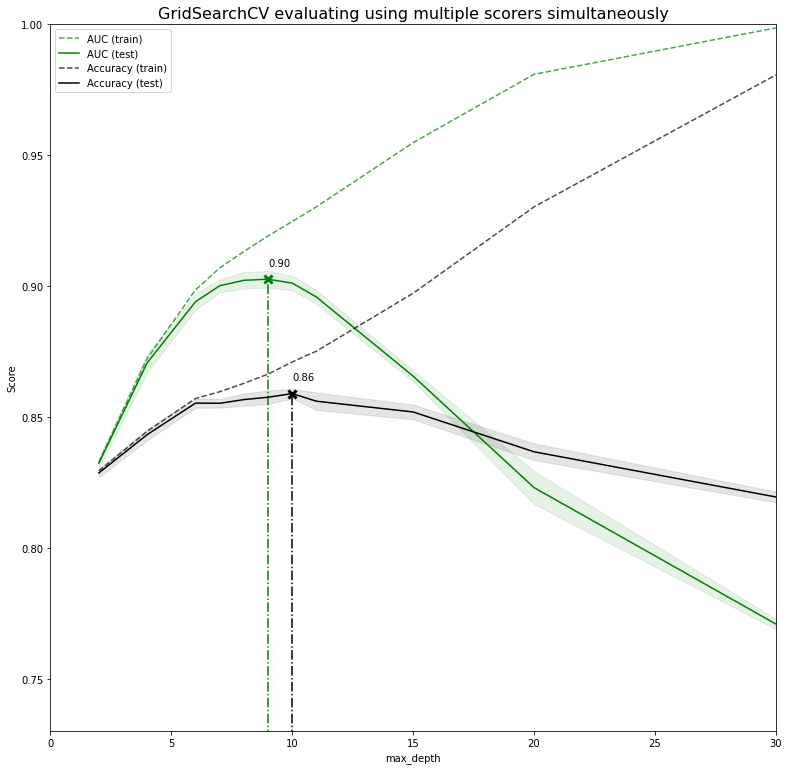

In [14]:
from matplotlib import pyplot as plt
plot_results(gs.cv_results_)

### Callable `refit`

This example balances model complexity and cross-validated score by
finding a decent score within 1 standard deviation of the best AUC score while minimising model complexity [1].

[1] Hastie, T., Tibshirani, R.,, Friedman, J. (2001). Model Assessment and
Selection. The Elements of Statistical Learning (pp. 219-260). New York,
NY, USA: Springer New York Inc..

In [15]:
def lower_bound(cv_results):
    """
    Calculate the lower bound within 1 standard deviation
    of the best `mean_test_AUC`.
    """
    best_score_idx = np.argmax(cv_results['mean_test_AUC'])

    return (cv_results['mean_test_AUC'][best_score_idx]
            - cv_results['std_test_AUC'][best_score_idx])


def best_low_complexity(cv_results):
    """
    Balance model complexity with cross-validated score.
    """
    threshold = lower_bound(cv_results)
    candidate_idx = np.flatnonzero(cv_results['mean_test_AUC'] >= threshold)
    best_idx = candidate_idx[cv_results['param_max_depth']
                             [candidate_idx].argmin()]
    return best_idx


In [16]:
gs_refit = GridSearchCV(DecisionTreeClassifier(random_state=42),
                       param_grid=param_grid,
                       scoring=scoring,
                       refit=best_low_complexity,
                       return_train_score=True,
                       n_jobs=6)
gs_refit.fit(X, y)
gs_refit.best_estimator_

DecisionTreeClassifier(max_depth=7, random_state=42)

### Choosing a point on a pareto curve
The above API would ideally enable us to choose a model based on the pareto frontier of error

In [17]:
def plot_pareto_curve():
    plt.xlabel("Error")
    plt.ylabel("Fairness Violation")
    plt.title("Pareto Frontier")
    ax = plt.gca()
    plt.gcf().set_size_inches(10, 7)
    scores = [.50, .53, .60, .65, .70, .80, .85, .88, .90]
    fairness = [.80, .50, .35, .25, .20, .16, .14, .12, .11] 
    ax.plot(scores, fairness)
    plt.plot([.5, .9], [.2, .2], color='orange')
    plt.show()

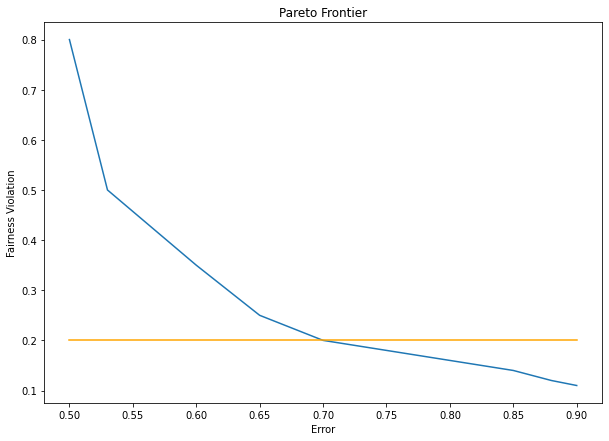

In [18]:
plot_pareto_curve()

In [19]:
def best_low_complexity(cv_results):
    threshold = lower_bound(cv_results)
    candidate_idx = np.flatnonzero(cv_results['mean_test_AUC'] >= threshold)
    best_idx = candidate_idx[cv_results['param_max_depth']
                             [candidate_idx].argmin()]
    return best_idx

In [20]:
def best_model_selector(cv_results):
    threshold = lower_bound(cv_results)
    candidate_idx = np.flatnonzero(
        np.logical_and(cv_results['mean_test_AUC'] >= threshold,
                       cv_results['mean_test_fairness_violation'] < .2))
    best_idx = candidate_idx[cv_results['param_max_depth']
                             [candidate_idx].argmin()]
    return best_idx

## Tools
### Fairlearn
Started by Microsoft
- fairlearn.metrics
- fairlearn.postprocessing
- fairlearn.reductions
- fairlearn.datasets

Defaulting on sklearn compatibility, but there are many challenges ahead.

## Tools
### AIF360
Started by IBM
- aif360.algorithms
  - preprocessing
  - inprocessing
  - postprocessing
- aif360.datasets
- aif360.metrics
- aif360.sklearn
  - metrics
  - preprocessing
  - inprocessing
  - postprocessing
  
Datasets are a key, and the sklearn submodule expects a pandas DataFrame with sensitive attributes on the index, so not really sklearn compatible.

## scikit-learn API enhancments
- Sample Properties
- Feature Names
- Resamplers

## Sample Properties

This requires passing sensitive attributes to the scorer!
- Sample aligned properties -> [SLEP006](https://scikit-learn-enhancement-proposals.readthedocs.io/en/latest/slep006/proposal.html), [PR#16079](https://github.com/scikit-learn/scikit-learn/pull/16079)

``` python
equalized_odds_scorer = make_scorer(equalized_odds_ratio, request_props=["gender"])
estimator = make_pipeline(
    DisparateImpactRemover().request_sensitive_attribute(fit='gender'),
    SVC().request_sample_weight(fit=True)
gs = GridSearchCV(estimator,
                  param_grid=param_grid,
                  scoring=['roc_auc', equalized_odds_scorer],
                  refit=best_model_selector)
gs.fit(X, y, sample_weight=sample_weight, gender=data['gender'])
```

## Feature Names

Including sensitive attributes in the data and taking them into account

Imagine such a pipeline:
``` python
make_pipeline(ColumnTransformer(...), XTransformer(...), ..., XClassifier())
```

It'd be nice to be able to pass the names of the features to estimators and inspect those feature names within a pipeline:

``` python
XTransformer(..., sensitive_attributes=["x", "y", "z"])
```

This requires feature names to be propagated in a pipeline. Soon you may be able to pass a `pandas.DataFrame` or an `xarray.DataArray` and have them be passes as such in a pipeline, preserving feature names, and creating new meaningful feature names if necessary: [PR#16771](https://github.com/scikit-learn/scikit-learn/pull/16772), [SLEP007](https://scikit-learn-enhancement-proposals.readthedocs.io/en/latest/slep007/proposal.html), [SLEP012](https://scikit-learn-enhancement-proposals.readthedocs.io/en/latest/slep012/proposal.html), [SLEP014](https://github.com/scikit-learn/enhancement_proposals/pull/37), [SLEP015](https://github.com/scikit-learn/enhancement_proposals/pull/48)

You can then also inspect models using `.feature_names_in_` and probably a `.feature_names_out_` attribute.

Calling a transformer would look like:

``` python
df_transformed = transformer.transform(df, y, output_type='dataframe')
```

## Resamplers and reweighing
- Currently sklearn doesn't really support resampling in a `pipeline`, either through `sample_weight` or by changing the `X`
- Introducing resamplers: [SLEP005](https://github.com/scikit-learn/enhancement_proposals/pull/15/files)
- Example usage:

``` python
est = make_pipeline(Resampler(), SVC())
```

Resamplers would implement a `.fit_resample()` method.

## Concluding Remarks
- More and more groups/companies are releasing their tools
- Our toolset were not designed having fairness related requirements in mind
- There's been significant efforts in the community, and I'm very excited about 2021!

# Thank YOU!

## Questions